<a href="https://colab.research.google.com/github/BrouthenKamel/HAICK-2023/blob/main/Sonatrach_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [6]:
data_path = '/gdrive/MyDrive/Sonatrach_Dataset'

In [7]:
data_sample = pd.read_csv(data_path+'/sample.csv')
data_train = pd.read_csv(data_path+'/train_dataset.csv')
data_test = pd.read_csv(data_path+'/test_dataset.csv')

In [8]:
target_col = "ROP (Time)"

<AxesSubplot:>

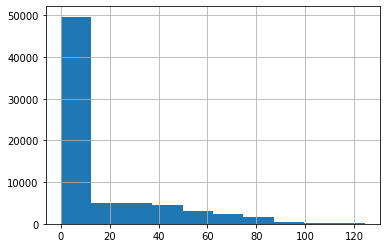

In [9]:
data_train[target_col].hist()

In [ ]:
for col in data_train.columns:
    if col != target_col:
        plt.figure()
        sns.scatterplot(x=col, y=target_col, data=data_train)
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.title(f'{col} vs {target_col}')
        plt.show()

In [ ]:
corr = data_train.corr()

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size': 12}, square=True)

plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr[target_col][ (corr[target_col] > 0.1) | (corr[target_col] < -0.1)].index

In [ ]:
lin_correlated = ['Depth: TMD', 'Bit Position', 'Torque Min', 'Torque Avg', 'Torque Max',
       'WOH Max', 'WOH Avg', 'WOH Inst', 'WOB Max', 'WOB Avg', 'ROP (Time)',
       'RPM Avg', 'RPM Inst', 'Flow In Pumps', 'Flow Paddle',
       'Pressure: SPP Avg', 'Weight: Overpull Max', 'Hook Position',
       'Mud: MWO Avg', 'Mud:Temperature IN Avg', 'Pit 3 Volume',
       'Pit 4 Volume', 'Pit 5 Volume', 'Pit 6 Volume', 'Gas Main: C1',
       'Gas Main: C2', 'Gas Main: C3', 'Gas Main: nC4']

In [ ]:
#drop_cols = [ "Bit Position", "Torque Min", "WOH Inst", "WOH Max", "WOB Max", "Gas Main: C1", "Gas Main: C3", "Weight: Overpull Max", "Weight: Drag Max"]

In [ ]:
#data_train.drop(columns = drop_cols, inplace = True)
#data_test.drop(columns = drop_cols, inplace = True)

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
mi_scores = make_mi_scores(data_train.drop(columns = ["ROP (Time)"]), data_train["ROP (Time)"])
mi_scores[mi_scores > 0.5].index

In [ ]:
useful_columns = ['Depth: TMD', 'Bit Position', 'Gas Main: C1', 'Flow In Pumps',
       'RPM Avg', 'Pressure: SPP Avg', 'Mud:Temperature IN Avg',
       'Pit 2 Volume', 'RPM Inst', 'WOB Avg', 'WOB Max', 'Hook Position',
       'Pit 5 Volume', 'Gas Main: C2', 'Pit 6 Volume', 'WOH Avg', 'WOH Max',
       'Gas Main: nC4', 'Pit 4 Volume', 'Pit 3 Volume', 'Torque Max',
       'WOH Inst', 'Torque Avg', 'Torque Min', 'Mud: Temperature OUT Avg',
       'Gas Main: C3', 'Gas Main: iC5', 'Gas Main: nC5', 'Flow Paddle']

In [ ]:
use_cols = [ x for x in data_train.columns if x in lin_correlated and x in useful_columns ]

In [10]:
X = data_train.drop(columns = ["ROP (Time)"])
y = data_train["ROP (Time)"]

In [ ]:
X = data_train[use_cols]
y = data_train["ROP (Time)"]

In [11]:
scalerX = StandardScaler()
X_standardized = scalerX.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

In [12]:
scalery = StandardScaler()
y_standardized = scalery.fit_transform(y.values.reshape(-1, 1))
y_mean = scalery.mean_[0]
y_std = scalery.scale_[0]

In [13]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_standardized)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,5.761816,-2.503586,0.082445,1.109747,-2.498940,0.197451,1.267715,-0.179587,-0.705152,0.410927,...,-0.146397,-0.021754,-0.506985,0.241559,0.918510,0.162330,0.561252,-0.590410,-0.488346,0.318559
1,5.688759,-2.549047,-0.008387,1.107061,-2.529669,0.209672,1.285583,-0.142858,-0.717039,0.421388,...,-0.096702,-0.037665,-0.512749,0.269673,0.965225,0.159827,0.624168,-0.609285,-0.508186,0.301877
2,5.785639,-2.508448,0.069646,1.205118,-2.467734,0.137754,1.254297,-0.160977,-0.717796,0.392223,...,-0.308470,-0.055265,-0.484436,0.213117,0.890046,0.158270,0.551071,-0.548606,-0.471599,0.319178
3,5.759341,-2.522675,0.036974,1.206588,-2.474869,0.136152,1.254821,-0.131316,-0.724474,0.398807,...,-0.351706,-0.077344,-0.472904,0.220540,0.916495,0.170114,0.589656,-0.597222,-0.481654,0.319712
4,5.813274,-2.440876,0.241392,0.865381,-2.553367,0.346314,1.298457,-0.333341,-0.661657,0.412831,...,0.267152,0.100973,-0.589734,0.268322,0.895075,0.136298,0.451415,-0.514898,-0.492649,0.308155


In [ ]:
X_pca.shape

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_standardized, test_size=0.2, random_state=20)

In [17]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
model = Sequential(
    [
    Dense(92, activation='relu', kernel_initializer='normal'),
     Dense(64, activation = 'relu', kernel_initializer='normal'),
     Dense(64, activation='relu', kernel_initializer='normal'),
     Dense(64, activation='relu', kernel_initializer='normal'),
    Dense(1, activation='linear', kernel_initializer='normal')
    ]
)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmse])

In [28]:
model.fit(X_train.to_numpy(), y_train, epochs=20 , validation_split=0.2)

Epoch 1/20
1440/1440 [==============================] - 7s 4ms/step - loss: 0.0505 - rmse: 0.2127 - val_loss: 0.0642 - val_rmse: 0.2387
Epoch 2/20
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0485 - rmse: 0.2079 - val_loss: 0.0646 - val_rmse: 0.2361
Epoch 3/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.0478 - rmse: 0.2064 - val_loss: 0.0597 - val_rmse: 0.2278
Epoch 4/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.0459 - rmse: 0.2022 - val_loss: 0.0622 - val_rmse: 0.2343
Epoch 5/20
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0448 - rmse: 0.1996 - val_loss: 0.0555 - val_rmse: 0.2219
Epoch 6/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.0452 - rmse: 0.1996 - val_loss: 0.0552 - val_rmse: 0.2201
Epoch 7/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.0427 - rmse: 0.1945 - val_loss: 0.0550 - val_rmse: 0.2198
Epoch 8/20
1440/1440 [==========================

In [29]:
loss, metric = model.evaluate(X_test, y_test)

450/450 [==============================] - 1s 2ms/step - loss: 0.0522 - rmse: 0.2119


In [ ]:
data_test = data_test[use_cols]

In [30]:
data_test_standard = scalerX.transform(data_test)

data_test_pca = pca.transform(data_test_standard)
print(data_test_pca.shape)
component_names = [f"PC{i+1}" for i in range(data_test_pca.shape[1])]
data_test_pca = pd.DataFrame(data_test_pca, columns=component_names)

data_predict = model.predict(data_test_pca.to_numpy())

submission = dict()
submission["id"] = []
submission["ROP (Time)"] = []

for index, row in enumerate(data_predict):
  submission["id"].append(index)
  submission["ROP (Time)"].append(row[0] * y_std + y_mean )

submit = pd.DataFrame(submission)
submit.to_csv('/content/last.csv', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(14394, 25)
450/450 [==============================] - 3s 5ms/step


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
}

#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

rf.fit(X_train, y_train.reshape(-1, 1))

#print("Best parameters:", grid_search.best_params_)
#print("Best score:", -grid_search.best_score_)

#best_rf = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
#                                 max_depth=grid_search.best_params_['max_depth'],
 #                                )

#best_rf.fit(X, y)

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean squared error:", rmse)

<ipython-input-46-667210690c61>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train.reshape(-1, 1))


In [44]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate = 0.01, n_estimators = 20)

param_grid = {
    'learning_rate': [0.01, 0.1],
}

#grid_search = GridSearchCV(xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)

xgb.fit(X_train, y_train)

#print("Best Parameters: ", grid_search.best_params_)
#print("MSE: ", -grid_search.best_score_)

#best_xgb = XGBRegressor(**grid_search.best_params_)
#best_xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE on test set: ", np.sqrt(mse))

[08:46:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set:  0.9724723526717031
